In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [91]:
from datetime import datetime

In [69]:
API_KEY = '5364a693bffc60a1855fd7ee99d3ca50'
cities = ['London', 'New York', 'Tokyo', 'Moscow', 'Sydney']
weather_data = []

# Получаем данные о погоде за последний месяц
for city in cities:
    for days in range(30):
        date = (datetime.now() - timedelta(days=days)).strftime('%Y-%m-%d')
        url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&dt={date}'
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            temp = data['main']['temp'] - 273.15  # Конвертация из Кельвинов в Цельсий
            weather_data.append({'city': city, 'date': date, 'temperature': temp})


In [11]:
# Создаем DataFrame
df = pd.DataFrame(weather_data)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         150 non-null    object 
 1   date         150 non-null    object 
 2   temperature  150 non-null    float64
dtypes: float64(1), object(2)
memory usage: 3.6+ KB


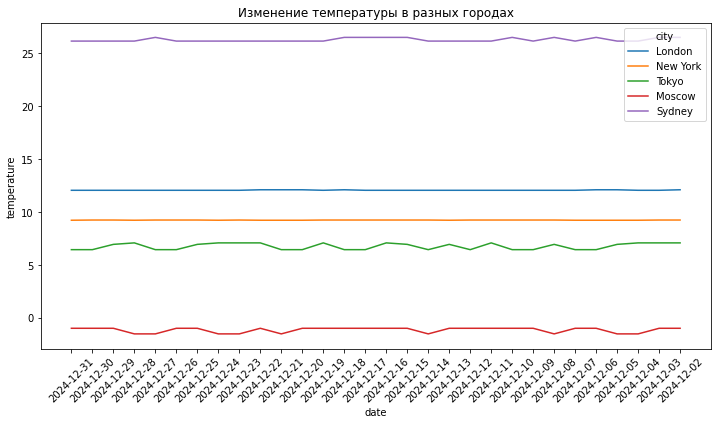

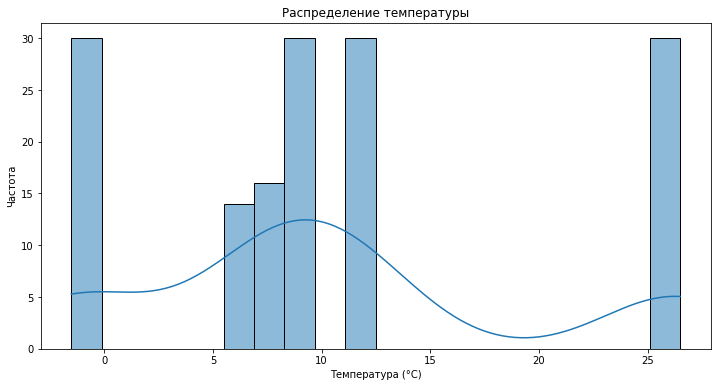

In [15]:
# График изменения температуры
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='temperature', hue='city')
plt.title('Изменение температуры в разных городах')
plt.xticks(rotation=45)
plt.show()

# График распределения температуры
plt.figure(figsize=(12, 6))
sns.histplot(df['temperature'], bins=20, kde=True)
plt.title('Распределение температуры')
plt.xlabel('Температура (°C)')
plt.ylabel('Частота')
plt.show()

In [92]:
#Сохраняем в локальный csv файл
local_file = f'weather_{datetime.now().strftime("%d-%m-%Y_%H-%M-%S")}.csv' 
df.to_csv(local_file, index=False, encoding='utf-8')

In [93]:
from pyspark.sql import SparkSession
import os

In [94]:

# Создание Spark-сессии
spark = SparkSession.builder \
    .appName("HDFS File Operations") \
    .master("local") \
    .getOrCreate()

# Путь к файлу на локальной машине
local_file_path = f'/opt/workspace/weather/{local_file}'
# Путь в HDFS
hdfs_file_path = f'hdfs://namenode:8020/user/admin/weather_data/{local_file}'

# Проверка существования локального файла
if not os.path.isfile(local_file_path):
    print(f"Локальный файл не существует: {local_file_path}")
else:
    print(f"Загружаем локальный файл: {local_file_path}")

    # Получение конфигурации Hadoop
    hadoop_conf = spark._jsc.hadoopConfiguration()
    hadoop_conf.set("fs.defaultFS", "hdfs://namenode:8020")

    # Получение файловой системы HDFS
    hadoop_fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(hadoop_conf)

    # Создание объектов Path для локального файла и HDFS
    local_path = spark._jvm.org.apache.hadoop.fs.Path(local_file_path)
    hdfs_path = spark._jvm.org.apache.hadoop.fs.Path(hdfs_file_path)

    # Загрузка файла в HDFS
    try:
        hadoop_fs.copyFromLocalFile(local_path, hdfs_path)
        print("Файл, загруженный в HDFS")
    except Exception as e:
        print(f"Ошибка при загрузке файла в HDFS: {e}")

# Остановка Spark-сессии
spark.stop()


Загружаем локальный файл: /opt/workspace/weather/weather_01-01-2025_11-10-34.csv
Файл, загруженный в HDFS


In [95]:
# Создание Spark-сессии
spark = SparkSession.builder \
    .appName("HDFS File Operations") \
    .master("local") \
    .getOrCreate()

# Путь в HDFS
hdfs_file_path = f'hdfs://namenode:8020/user/admin/weather_data/{local_file}'
# Путь для сохранения файла на локальной машине
local_download_path = f'/opt/workspace/weather/downloaded_{local_file}'

# Получение конфигурации Hadoop
hadoop_conf = spark._jsc.hadoopConfiguration()
hadoop_conf.set("fs.defaultFS", "hdfs://namenode:8020")

# Получение файловой системы HDFS
hadoop_fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(hadoop_conf)

# Создание объекта Path для HDFS файла и локального пути
hdfs_path = spark._jvm.org.apache.hadoop.fs.Path(hdfs_file_path)
local_path = spark._jvm.org.apache.hadoop.fs.Path(local_download_path)

# Скачивание файла из HDFS
try:
    hadoop_fs.copyToLocalFile(hdfs_path, local_path)
    print(f"Файл downloaded_{local_file}, загружен из HDFS на локальный компьютер")
except Exception as e:
    print(f"Ошибка при загрузке файла из HDFS: {e}")

# Остановка Spark-сессии
spark.stop()


Файл downloaded_weather_01-01-2025_11-10-34.csv, загружен из HDFS на локальный компьютер
